# Disaster tweets classifier

Explanation of project goal -> analyze tweets classifying them into disaster and non-disaster ones to extract useful information during crises

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

Using TensorFlow backend.


## 1. EDA

### 1.1 Read train and test datasets

In [2]:
train = pd.read_csv('./input/tweets_data/train.csv')
test = pd.read_csv('./input/tweets_data/test.csv')

train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2 Get the total number of samples in both datasets

In [3]:
train_total_rows = train.shape[0]
test_total_rows = test.shape[0]

print(f"Total number of train samples = {train_total_rows} \n\
Total number of test samples = {test_total_rows}")

Total number of train samples = 7613 
Total number of test samples = 3263


### 1.3 Checking class distribution

Total number of disaster samples (1) = 3271 
Total number of non disaster samples (0) = 4342


Text(0, 0.5, 'train tweets')

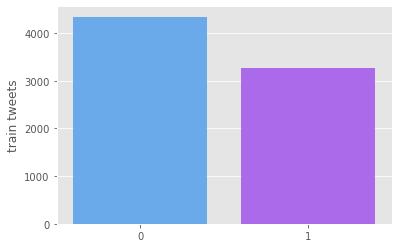

In [4]:
x = train.target.value_counts()
print(f"Total number of disaster samples (1) = {x[1]} \n\
Total number of non disaster samples (0) = {x[0]}")

sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('train tweets')

### 1.4 Get number of characters in tweets

Text(0.5, 0.98, '# Characters in tweets')

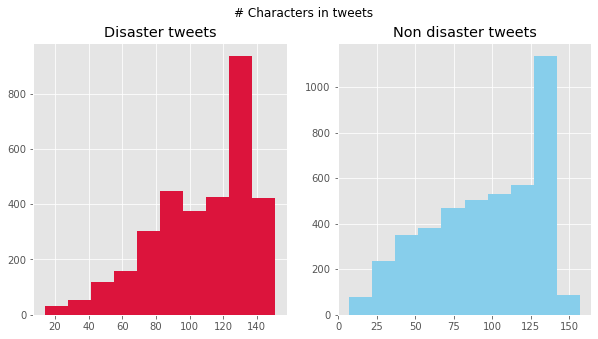

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('# Characters in tweets')

### 1.5 Get number of words in each tweet

Text(0.5, 0.98, 'Words in a tweet')

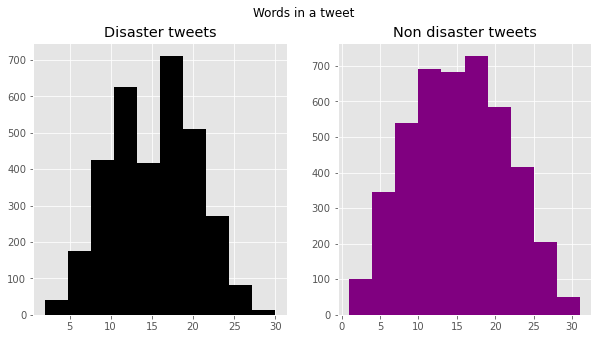

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='black')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

### 1.6 Calculate the average word length in each tweet

Text(0.5, 0.98, 'Average word length in each tweet')

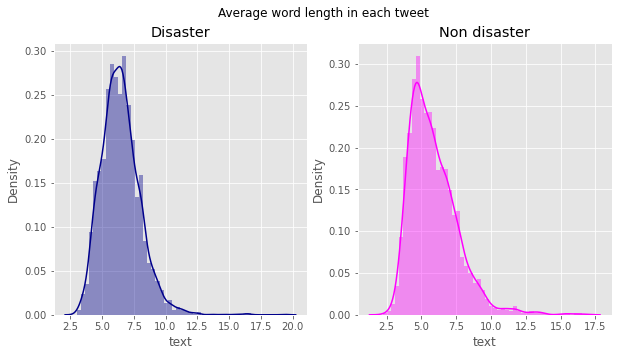

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster')
word = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='magenta')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

### 1.7 Create a corpus function

In [8]:
def create_corpus_df(df, target):
    """
        Create a corpus from a give df for a target class
        
        df: Pandas dataframe
        target: class identifier
    """
    
    corpus=[]
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### 1.8 Analize punctuations marks in non-disaster class (0)

<BarContainer object of 20 artists>

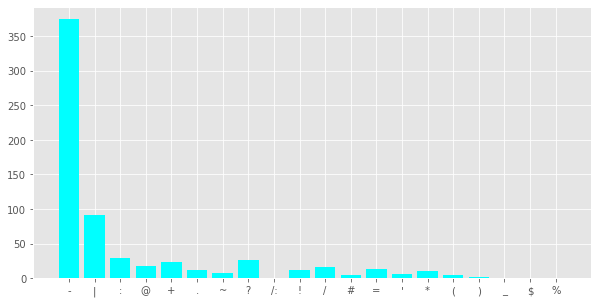

In [9]:
plt.figure(figsize=(10,5))
corpus = create_corpus_df(train, 0)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.bar(x, y,color='cyan')

### 1.9 Analize punctuations marks in disaster class (1)

<BarContainer object of 18 artists>

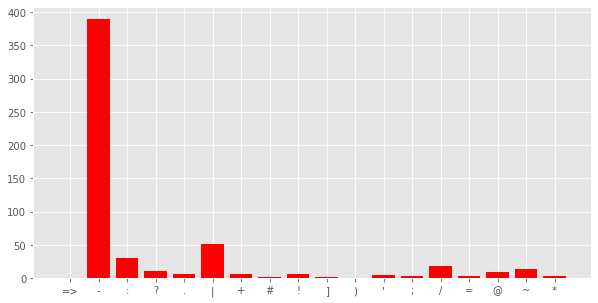

In [10]:
plt.figure(figsize=(10,5))
corpus = create_corpus_df(train, 1)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y = zip(*dic.items())
plt.bar(x, y, color='red')

### 1.10 Download stopwords

In [11]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.11 Get the most common words

<AxesSubplot:>

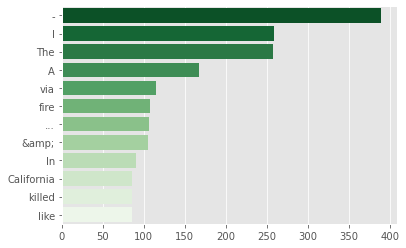

In [12]:
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stopwords) :
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x, palette='Greens_r')

### 1.12 Bigram analysis

<AxesSubplot:>

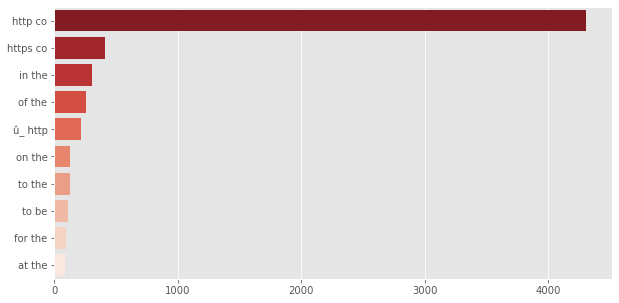

In [13]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')

## 2. Data cleaning

### 2.1 Renaming location names

<AxesSubplot:xlabel='location'>

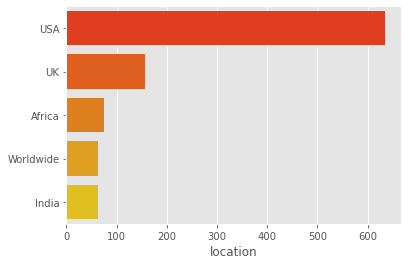

In [14]:
df = pd.concat([train,test])
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],
            palette='autumn', orient='h')

In [15]:
def clean_text(text):
    """
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

### 2.2 Applying the cleaning function to both test and training datasets

In [16]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### 2.3 Removing emojis

In [17]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [18]:
train_values = train.text.values
test_values = test.text.values
train_classes = train.target.values

## 3. Preprocessing

### 3.1 Tokenization

Firt, it is necessary to perform tokenization to split the text into sentences of words. With this tokenization step we get the text into a format that is easier to convert to raw numbers, which can actually be used for the model later.

In [19]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_values)
vocab_length = len(word_tokenizer.word_index) + 1

In [20]:
def report_metrics(prediction_tag, y_test):
    print("F1-score: ", f1_score(prediction_tag, y_test))
    print("Precision: ", precision_score(prediction_tag, y_test))
    print("Recall: ", recall_score(prediction_tag, y_test))
    print("Acuracy: ", accuracy_score(prediction_tag, y_test))
    print("-"*50)
    print(classification_report(prediction_tag, y_test))

def embed(tokenizer, corpus): 
    return tokenizer.texts_to_sequences(corpus)

In [21]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [22]:
nltk.download('punkt')

longest_train = max(train_values, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(word_tokenizer, train_values), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(word_tokenizer, test_values), 
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 3.2 GloVe

To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!mkdir ./input/glove6b
!unzip -q glove.6B.zip -d ./input/glove6b

--2021-03-28 17:24:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-28 17:24:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-28 17:24:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
embeddings_dictionary = dict()
embedding_dim = 100
with open('./input/glove6b/glove.6B.100d.txt') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [25]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
!rm -rf ./input/glove6b
!rm glove.6B.zip

## 4. Model preparation and implementation

For solving this problem I decided to use LSTM (long short-term memory) model because it solves a vanishing gradient problem.

### 4.1 Splitting data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    train_classes, 
    test_size=0.25
)

### 4.2 Model implementation

In [28]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BLSTM()

In [29]:
!pip install pydot

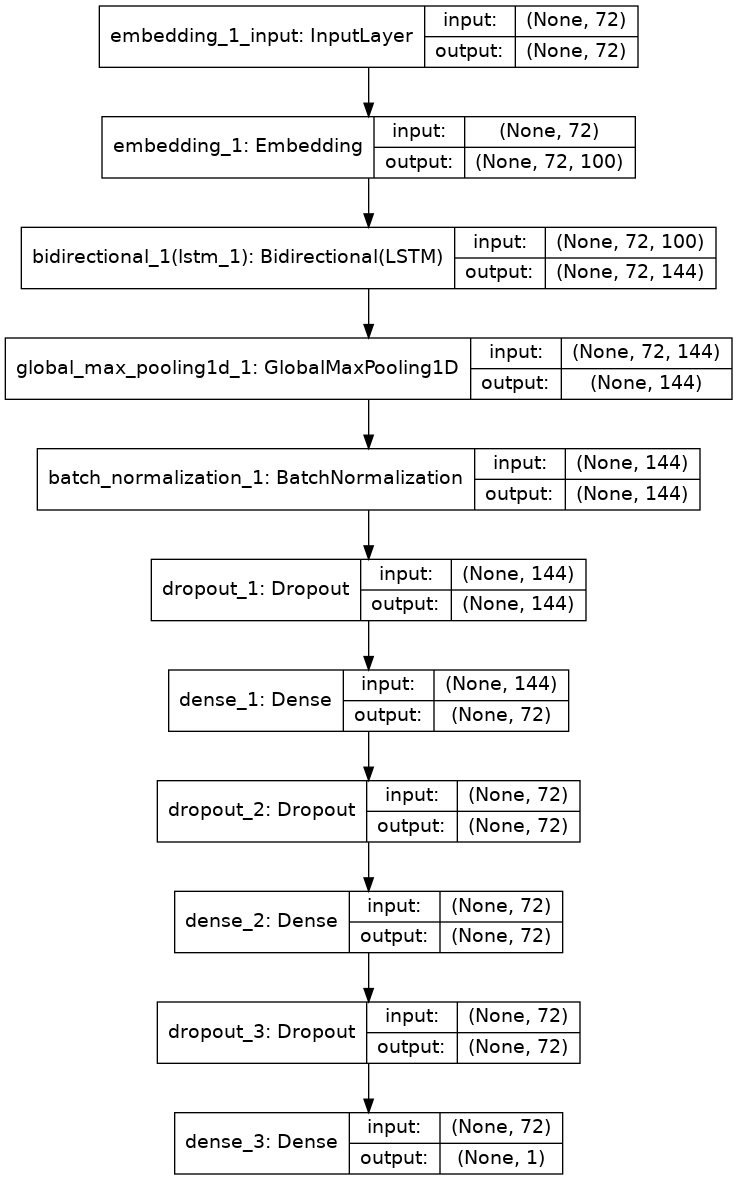

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 4.3 Model training

In [31]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/7
5709/5709 [==============================] - 42s 7ms/step - loss: 0.6410 - accuracy: 0.6842 - val_loss: 0.5682 - val_accuracy: 0.7931

Epoch 00001: val_loss improved from inf to 0.56819, saving model to model.h5
Epoch 2/7
5709/5709 [==============================] - 35s 6ms/step - loss: 0.5034 - accuracy: 0.7765 - val_loss: 0.4660 - val_accuracy: 0.8057

Epoch 00002: val_loss improved from 0.56819 to 0.46599, saving model to model.h5
Epoch 3/7
5709/5709 [==============================] - 35s 6ms/step - loss: 0.4497 - accuracy: 0.8063 - val_loss: 0.4335 - val_accuracy: 0.8057

Epoch 00003: val_loss improved from 0.46599 to 0.43352, saving model to model.h5
Epoch 4/7
5709/5709 [==============================] - 38s 7ms/step - loss: 0.4286 - accuracy: 0.8226 - val_loss: 0.4240 - val_accuracy: 0.8114

Epoch 00004: val_loss improved from 0.43352 to 0.42401, saving model to model.h5
Epoch 5/7
5709/5709 [==============================]

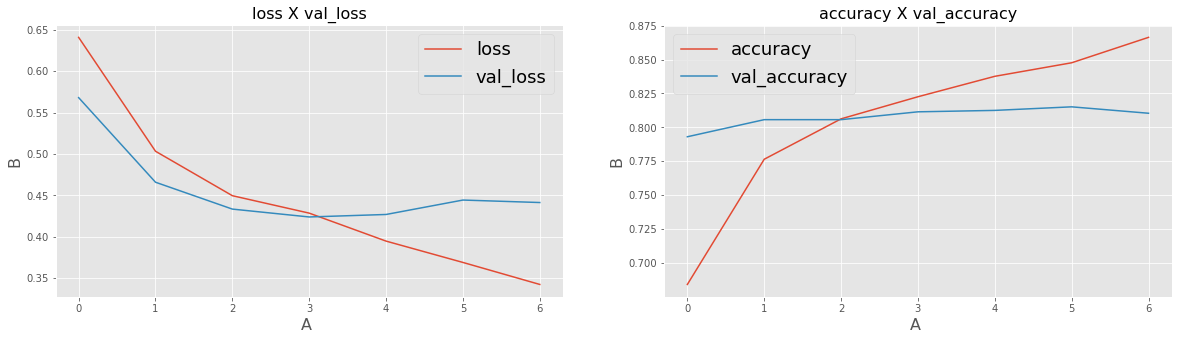

In [32]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

## 5 Model evaluation

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

1904/1904 [==============================] - 1s 774us/step
Loss: 0.4414563239121637
Accuracy: 0.8103991746902466


### 5.1 Model reporting

In [34]:
preds = model.predict_classes(X_test)
report_metrics(preds, y_test)

F1-score:  0.7508626639061422
Precision:  0.6766169154228856
Recall:  0.8434108527131783
Acuracy:  0.8103991596638656
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1259
           1       0.68      0.84      0.75       645

    accuracy                           0.81      1904
   macro avg       0.79      0.82      0.80      1904
weighted avg       0.83      0.81      0.81      1904



In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb = MultinomialNB()

nb.fit(X_train, y_train)
pred_class = nb.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(y_test, pred_class))
print("Precision", metrics.precision_score(y_test, pred_class))
print("Recall", metrics.recall_score(y_test, pred_class))
print("Recall", metrics.f1_score(y_test, pred_class))

Accuracy:  0.5845588235294118
Precision 0.5075669383003493
Recall 0.5422885572139303
Recall 0.5243535778713169
